# Import essential libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer
import pyLDAvis.sklearn

In [2]:
def lemma_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

In [3]:
main_df = pd.read_csv('NYT2000_1.csv', usecols=['Body', 'Publication Day Of Month', 'Publication Month', 'Publication Year'])
temp_df = pd.read_csv('NYT2000_2.csv', usecols=['Body', 'Publication Day Of Month', 'Publication Month', 'Publication Year'])
main_df = pd.concat([main_df,temp_df], ignore_index=True)

In [4]:
# Remove NaN values, lowercase contents of Body column, filters for bush and gore and resets the index
print(main_df.shape)
main_df.dropna(subset=['Body'], inplace=True)
print(main_df.shape)

main_df['Body'] = main_df['Body'].str.lower()
main_df = main_df[main_df['Body'].str.contains('gore|bush')]
main_df = main_df.reset_index(drop=True)

(50130, 4)
(49471, 4)


In [5]:
# Create a single date column from day, month and year columns
main_df['Date'] = pd.to_datetime(
    main_df['Publication Year'] * 10000 + main_df['Publication Month'] * 100 + main_df['Publication Day Of Month'],
    format='%Y%m%d')
main_df.drop(['Publication Year', 'Publication Month', 'Publication Day Of Month'], axis=1, inplace=True)
print(main_df.shape)

(4706, 2)


In [6]:
# Remove unnecessary symbols, numbers, words less than 3 characters and apply lemmatizer
main_df['Body'].replace([r'[,\.!?]', r'\d+', r'\b(\w{1,2})\b'], '', inplace=True, regex=True)
main_df['Body'].apply(lemma_text)
main_df['Body'] = main_df['Body'].str.replace('said', '', regex=False)
print(main_df['Body'].head(10))

0    just before the july  recess  senate committee...
1    george  bush -- pittsburgh and east brunswick ...
2    drivers have been paying almost twice  much fo...
3    for farmers the months leading  harvest time a...
4    international -  and vietnam reach broad trade...
5    dna test fails  exonerate prisoner given stay ...
6    former senator bill bradley made  official tod...
7    from his opening salutation ''   member  the n...
8    the democratic national committee' new televis...
9    several homeowners cell phones  hand tend thei...
Name: Body, dtype: object


In [7]:
# Generate doc-term matrix
cv = CountVectorizer(stop_words='english', max_df=3500)
ft_cv = cv.fit_transform(main_df['Body'])
vocabulary = cv.get_feature_names()

doc_term_matrix = pd.DataFrame(ft_cv.toarray(), columns=vocabulary)
print(doc_term_matrix.shape)

(4706, 63104)


In [8]:
import numpy as np
from sklearn.utils import check_random_state
from sklearn.decomposition._online_lda_fast import _dirichlet_expectation_2d
class PTWGuidedLatentDirichletAllocation(LatentDirichletAllocation):

    def __init__(self, n_components=10, *, doc_topic_prior=None,
                 topic_word_prior=None, learning_method='batch',
                 learning_decay=.7, learning_offset=10., max_iter=10,
                 batch_size=128, evaluate_every=-1, total_samples=1e6,
                 perp_tol=1e-1, mean_change_tol=1e-3, max_doc_update_iter=100,
                 n_jobs=None, verbose=0, random_state=None, 
                 ptws=None):
        super(PTWGuidedLatentDirichletAllocation, self).__init__(n_components, doc_topic_prior, topic_word_prior, learning_method, learning_decay, learning_offset, max_iter, batch_size, evaluate_every, total_samples, perp_tol, mean_change_tol, max_doc_update_iter, n_jobs, verbose, random_state)
        self.ptws = ptws

    def _init_latent_vars(self, n_features):
        """Initialize latent variables."""

        self.random_state_ = check_random_state(self.random_state)
        self.n_batch_iter_ = 1
        self.n_iter_ = 0

        if self.doc_topic_prior is None:
            self.doc_topic_prior_ = 1. / self.n_components
        else:
            self.doc_topic_prior_ = self.doc_topic_prior

        if self.topic_word_prior is None:
            self.topic_word_prior_ = 1. / self.n_components
        else:
            self.topic_word_prior_ = self.topic_word_prior

        init_gamma = 100.
        init_var = 1. / init_gamma
        # In the literature, this is called `lambda`
        self.components_ = self.random_state_.gamma(
            init_gamma, init_var, (self.n_components, n_features))

        # Transform topic values in matrix for prior topic words
        if self.ptws is not None:
            for ptw in self.ptws:
                word_index = ptw[0]
                word_topic_values = ptw[1]
                self.components_[:, word_index] *= word_topic_values

        # In the literature, this is `exp(E[log(beta)])`
        self.exp_dirichlet_component_ = np.exp(
            _dirichlet_expectation_2d(self.components_))

In [9]:
# Fit LDA model to doc-term matrix
k = 15

lda = PTWGuidedLatentDirichletAllocation(n_components=15)

lda.fit(ft_cv)

print('log likelihood score, 15 topics: ' + str(lda.score(ft_cv)))
pyLDAvis.enable_notebook()
p = pyLDAvis.sklearn.prepare(lda, ft_cv, cv)
pyLDAvis.display(p)

C:\Users\JHuamani\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=batch, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17590202.292479195


(4706, 16)
(194, 15)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  0.773751  0.738901  1.924530  0.242327  1.043179  1.561756   
2000-05-02  0.009597  0.789136  0.488376  0.018879  0.009597  2.436571   
2000-05-03  1.008698  1.475940  0.281733  0.874870  0.372572  1.697222   
2000-05-04  0.089554  0.629976  0.790116  0.071952  0.747670  2.238165   
2000-05-05  0.681857  0.823355  1.495380  0.343254  1.765513  1.090262   
2000-05-06  0.010469  0.219271  0.148125  0.268512  1.766053  1.396763   
2000-05-07  1.540917  0.505122  1.213562  2.496162  1.827920  1.219181   
2000-05-08  0.047594  0.009144  0.044388  0.913462  0.997369  0.702826   
2000-05-09  0.012872  0.603193  1.461837  0.200211  1.745130  2.903696   
2000-05-10  0.682197  0.376112  1.505065  0.475995  0.154008  1.840431   

                  6         7         8         9         10        11  \
Date            

<Figure size 1152x720 with 0 Axes>

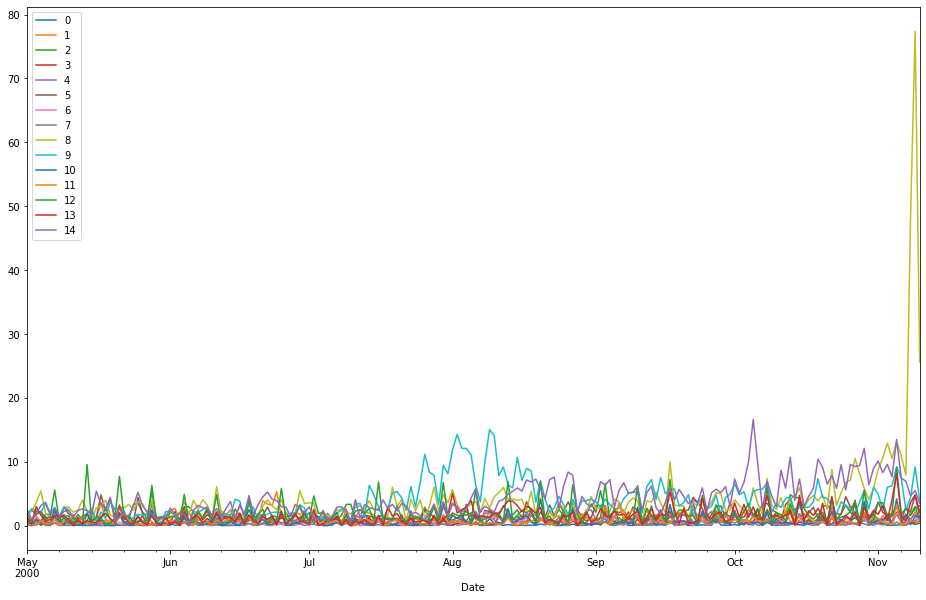

In [10]:
# Generate doc-topic matrix
lda_out = lda.transform(ft_cv)
doc_topic_matrix = pd.DataFrame(lda_out)
doc_topic_matrix['Date'] = main_df['Date']
print(doc_topic_matrix.shape)

aggregator = {i: 'sum' for i in range(k)}
coverage_curve = doc_topic_matrix.groupby(['Date']).agg(aggregator)
print(coverage_curve.shape)
print(coverage_curve.head(10))

plt.rcParams['figure.figsize'] = [16, 10]
plt.figure()
coverage_curve.plot()
plt.show()

In [11]:
#Read the IEM data and Normalize one of the stocks
iem_data = pd.read_excel('IEM2000.xlsx')
iem_data.drop(['Units', '$Volume', 'LowPrice','HighPrice','AvgPrice'], axis=1, inplace=True)

dem_data = iem_data[iem_data['Contract'].str.contains('Dem')]
rep_data = iem_data[iem_data['Contract'].str.contains('Rep')]

dem_data.set_index('Date', inplace=True)
rep_data.set_index('Date', inplace=True)

dem_data['NormLastPrice'] = dem_data['LastPrice'] / (dem_data['LastPrice'] + rep_data['LastPrice'])
dem_data.drop(['LastPrice', 'Contract'], axis=1, inplace=True)

print(dem_data.head())

            NormLastPrice
Date                     
2000-05-01       0.523810
2000-05-02       0.504970
2000-05-03       0.509491
2000-05-04       0.511466
2000-05-05       0.520875


C:\Users\JHuamani\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\JHuamani\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\JHuamani\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
<ipython-input-11-7b4d2e914db2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [12]:
combined_data = pd.concat([dem_data, coverage_curve], axis=1, join='inner')
print(combined_data.head())
print(combined_data.tail())
print(pd.date_range(start='2000-05-01',end='2000-11-10').difference(combined_data.index))


            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.773751  0.738901  1.924530  0.242327  1.043179   
2000-05-02       0.504970  0.009597  0.789136  0.488376  0.018879  0.009597   
2000-05-03       0.509491  1.008698  1.475940  0.281733  0.874870  0.372572   
2000-05-04       0.511466  0.089554  0.629976  0.790116  0.071952  0.747670   
2000-05-05       0.520875  0.681857  0.823355  1.495380  0.343254  1.765513   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  1.561756  0.114132  0.051342  2.187993  1.353131  0.600700   
2000-05-02  2.436571  0.188829  0.009597  2.215980  2.627411  0.009597   
2000-05-03  1.697222  1.105808  0.065822  3.557509  2.322442  1.013428   
2000-05-04  2.238165  0.562550  0.475327  5.416966  2.029649  0.456407   
20

In [13]:
from statsmodels.tsa.stattools import grangercausalitytests
granger_results1 = grangercausalitytests(combined_data[['NormLastPrice',2]],5)
granger_results2 = grangercausalitytests(combined_data[['NormLastPrice',7]],5)
granger_results3 = grangercausalitytests(combined_data[['NormLastPrice',10]],5)
granger_results4 = grangercausalitytests(combined_data[['NormLastPrice',11]],5)
granger_results5 = grangercausalitytests(combined_data[['NormLastPrice',12]],5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7397  , p=0.3909  , df_denom=190, df_num=1
ssr based chi2 test:   chi2=0.7513  , p=0.3861  , df=1
likelihood ratio test: chi2=0.7499  , p=0.3865  , df=1
parameter F test:         F=0.7397  , p=0.3909  , df_denom=190, df_num=1

Granger Causality
number of lags (no zero) 2


C:\Users\JHuamani\Anaconda3\lib\site-packages\patsy\constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


ssr based F test:         F=0.3955  , p=0.6739  , df_denom=187, df_num=2
ssr based chi2 test:   chi2=0.8122  , p=0.6662  , df=2
likelihood ratio test: chi2=0.8105  , p=0.6668  , df=2
parameter F test:         F=0.3955  , p=0.6739  , df_denom=187, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1333  , p=0.3369  , df_denom=184, df_num=3
ssr based chi2 test:   chi2=3.5292  , p=0.3170  , df=3
likelihood ratio test: chi2=3.4970  , p=0.3212  , df=3
parameter F test:         F=1.1333  , p=0.3369  , df_denom=184, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9536  , p=0.4344  , df_denom=181, df_num=4
ssr based chi2 test:   chi2=4.0039  , p=0.4055  , df=4
likelihood ratio test: chi2=3.9623  , p=0.4111  , df=4
parameter F test:         F=0.9536  , p=0.4344  , df_denom=181, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.0264  , p=0.4036  , df_denom=178, df_num=5
ssr based chi2 test: 